In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import timeit
from xgboost import XGBClassifier, plot_importance, DMatrix, plot_tree

## Load Data and Explore Data Structure

To save space, I will skip the exploration.
The dataset has 28 features and one target variable. No missing values.
V1-V28 have different scales, normalization would be needed.
Data is imbalanced.

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
print("Count of Fraud: {}".format(len(df[df.Class==1])))
print("Count of Normal: {}".format(len(df[df.Class==0])))
print("Percentage of Fraud: {:.2f}%".format(len(df[df.Class==1])/len(df)*100))
## Fraud only accounts for 0.17% of total data, data is highly imbalanced.

Count of Fraud: 492
Count of Normal: 284315
Percentage of Fraud: 0.17%


## Normalize data and Get Features and Target vavirable

In [4]:
## Normalize independant variables
X = df.drop(['Time','Amount','Class'],axis=1)
normalize = StandardScaler().fit(X)
X_normalized = normalize.transform(X)

In [5]:
y = df.Class

## Feature Selection
The features in this dataset already been transformed using PCA.
I will use select from model in this case. Recursive feature elimination method might get better results, but would take longer time.
I will only use LinearCSV to simplify the process in this case.

In [6]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
print("Original Features shape:{}".format(X_normalized.shape))
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_normalized, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_normalized)
print("New Features shape:{}".format(X_new.shape))

Original Features shape:(284807, 28)
New Features shape:(284807, 24)


## Split data into training and test

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=0.3,random_state=1234)

## Deal with imbalanced data
### 1. Use SMOTE to do oversampling
Undersampling would lose some information while oversampling might tend to overfitting.
I will compare oversampling method with cost sensitive method with a simple logistic model.

In [8]:
sm = SMOTE(random_state=12, kind='regular', ratio = 'auto')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0: 199013, 1: 351})
Resampled dataset shape Counter({0: 199013, 1: 199013})


### 2. Set cost for misclassification 
Add different cost weights for misclassification in each class, penalizing the misclassification of minority class.
I will set class_weight in each model.

### 3. Choose appropriate measures. 
I will tune and select best parameters for each model based on F measure, which measures both the precision and recall.
I will also select the most suitable model for my objectives.

### Define Measures for Classification

In [9]:
def classifier_measures(y_test,model_pred):
    # output confusion matrix
    print ("-------------------------------------Accuracy-----------------------------------------")
    Accuracy = accuracy_score(y_test, model_pred)
    print ("Accuracy:",Accuracy)
    print ("---------------------------------Confusion Matrix-------------------------------------")
    model_matrix = confusion_matrix(y_test, model_pred)
    # print ('Confusion matrix:\n',model_matrix)
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",model_matrix[1,1,]) # no of Fraud transaction which are predicted Fraud
    print("TN",model_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",model_matrix[0,1]) # no of normal transaction which are predicted Fraud
    print("FN",model_matrix[1,0]) # no of Fraud Transaction which are predicted normal
    sns.heatmap(model_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    
    print()
    print ("--------------------------------Precession and Recall---------------------------------")
    target_names = ['Normal',"Fraud"]
    print(classification_report(y_test, model_pred, target_names=target_names))

## Compare results from SMOTE and class_weight

### Logistic Regression with SMOTE

___________________________________Model Selection_____________________________________
Best estimator found by grid search: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best accuracy score found by grid search: 0.936858516106

_________________________________Model Prediction______________________________________
F1-measure: 0.0936819172113

-------------------------------------Accuracy-----------------------------------------
Accuracy: 0.970787542572
---------------------------------Confusion Matrix-------------------------------------
TP 129
TN 82818
FP 2484
FN 12


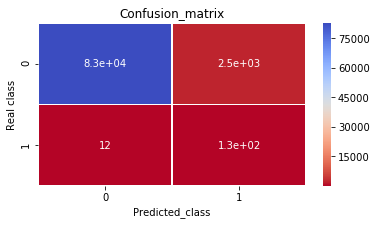


--------------------------------Precession and Recall---------------------------------
             precision    recall  f1-score   support

     Normal       1.00      0.97      0.99     85302
      Fraud       0.05      0.91      0.09       141

avg / total       1.00      0.97      0.98     85443



In [10]:
# Initialize classifier
lgr_b = LogisticRegression()

# Declare parameters to tune
C=np.arange(1,11,2)
lgr_b_params = {'C':C}
lgr_b_gs = GridSearchCV(lgr_b,lgr_b_params,scoring='f1',cv=5)
lgr_b_gs.fit(X_train_res,y_train_res)
print ("___________________________________Model Selection_____________________________________")
print ("Best estimator found by grid search:",lgr_b_gs.best_estimator_)
print ("Best accuracy score found by grid search:",lgr_b_gs.best_score_)
print ()

# Predict new values using best model derived from cross validation and test performance on the test set
lgr_b_pred = lgr_b_gs.predict(X_test)
lgr_b_prob = lgr_b_gs.predict_proba(X_test)
lgr_b_score = lgr_b_gs.score(X_test, y_test)
print ("_________________________________Model Prediction______________________________________")
print ('F1-measure:', lgr_b_score)
print ()
classifier_measures(y_test,lgr_b_pred)

In [11]:
start = timeit.default_timer()
lgr_b_gs.fit(X_train_res, y_train_res)
stop = timeit.default_timer()
print("Fitting Time: %s seconds" % (stop - start))

Fitting Time: 112.34885131647475 seconds


### Logistic Regression with class_weight

___________________________________Model Selection_____________________________________
Best estimator found by grid search: LogisticRegression(C=1, class_weight={0: 1, 1: 999}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best accuracy score found by grid search: 0.0663835507463

_________________________________Model Prediction______________________________________
F1-measure: 0.0606767794632

-------------------------------------Accuracy-----------------------------------------
Accuracy: 0.952892571656
---------------------------------Confusion Matrix-------------------------------------
TP 130
TN 81288
FP 4014
FN 11


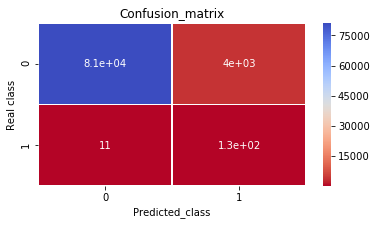


--------------------------------Precession and Recall---------------------------------
             precision    recall  f1-score   support

     Normal       1.00      0.95      0.98     85302
      Fraud       0.03      0.92      0.06       141

avg / total       1.00      0.95      0.97     85443



In [12]:
# Initialize classifier
lgr = LogisticRegression(class_weight = {0: 1, 1: 999})

# Declare parameters to tune
C=np.arange(1,11,2)
#class_weight =[{0: w} for w in [10, 20]]
lgr_params = {'C':C}
lgr_gs = GridSearchCV(lgr,lgr_params,scoring='f1',cv=5)
lgr_gs.fit(X_train,y_train)
print ("___________________________________Model Selection_____________________________________")
print ("Best estimator found by grid search:",lgr_gs.best_estimator_)
#print ("Best parameters found by grid search:",lgr_gs.best_params_)
print ("Best accuracy score found by grid search:",lgr_gs.best_score_)
print ()

# Predict new values using best model derived from cross validation and test performance on the test set
lgr_pred = lgr_gs.predict(X_test)
lgr_prob = lgr_gs.predict_proba(X_test)
lgr_score = lgr_gs.score(X_test, y_test)
print ("_________________________________Model Prediction______________________________________")
print ('F1-measure:', lgr_score)
print ()
classifier_measures(y_test,lgr_pred)

In [13]:
start = timeit.default_timer()
lgr_gs.fit(X_train, y_train)
stop = timeit.default_timer()
print("Fitting Time: %s seconds" % (stop - start))

Fitting Time: 70.63075077994165 seconds


### SMOTE is Synthetic Minority Over-sampling technique which still has high risk of overfitting as other oversampling techniques. According to the results, the model could achieve 0.91 recall but only 0.05 precision. If the objective of this case only focuses on high lost recall and tolerates all the false alert, this method might be appropriate. However, setting a higher class-weight such as 1:999 could get even better recall figure, and the fitting time would even be shorter. Therefore, I would prefer using class-weight rather than SMOTE.
### In this case, assume the objective it to achieve Fraud recall greater than 70% while Fraud precision would also be greater than 70%.  Therefore, company would not waste too much time to double check a lot of credit card transaction due to false alert. To balance the results, I would set class_weight as 1:15. To save training time, I will not try different class_weights in this exercise. However, to achieve better results in real case, I will also tune class_weight to find out the best parameter. 

## Model Comparison

### In this exercise, I will use logistic regression, random forest and XGboost model. Generally, logistic regression would take less time to train but random forest would be more robust. SVM would take too much time to train for high dimentional data, while GradientBoostingClassifier doesn't have class_weight parameter. XGboost would provide better results because it would learn from its own mistakes and use approximation algorithms to reduce training time. 

### Logistic Regression

___________________________________Model Selection_____________________________________
Best estimator found by grid search: LogisticRegression(C=1, class_weight={0: 1, 1: 15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best accuracy score found by grid search: 0.791459581794

_________________________________Model Prediction______________________________________
F1-measure: 0.746753246753

-------------------------------------Accuracy-----------------------------------------
Accuracy: 0.999087110705
---------------------------------Confusion Matrix-------------------------------------
TP 115
TN 85250
FP 52
FN 26


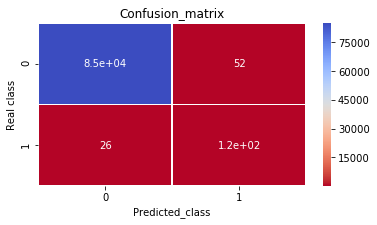


--------------------------------Precession and Recall---------------------------------
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     85302
      Fraud       0.69      0.82      0.75       141

avg / total       1.00      1.00      1.00     85443



In [29]:
# Initialize classifier
lgr = LogisticRegression(class_weight = {0: 1, 1: 15})

# Declare parameters to tune
C=np.arange(1,11,2)
lgr_params = {'C':C}
lgr_gs = GridSearchCV(lgr,lgr_params,scoring='f1',cv=5)
lgr_gs.fit(X_train,y_train)
print ("___________________________________Model Selection_____________________________________")
print ("Best estimator found by grid search:",lgr_gs.best_estimator_)
#print ("Best parameters found by grid search:",lgr_gs.best_params_)
print ("Best accuracy score found by grid search:",lgr_gs.best_score_)
print ()

# Predict new values using best model derived from cross validation and test performance on the test set
lgr_pred = lgr_gs.predict(X_test)
lgr_prob = lgr_gs.predict_proba(X_test)
lgr_score = lgr_gs.score(X_test, y_test)
print ("_________________________________Model Prediction______________________________________")
print ('F1-measure:', lgr_score)
print ()
classifier_measures(y_test,lgr_pred)

### Random Forest

_________________________________Model Selection_____________________________________
Best estimator found by grid search: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best parameters found by grid search: {'max_depth': 5, 'n_estimators': 200}
Best accuracy score found by grid search: 0.845213965569

________________________________Model Prediction_____________________________________
F1-measure: 0.783882783883

-------------------------------------Accuracy-----------------------------------------
Accuracy: 0.999309481175
---------------------------------Confusion Matrix-------------------------------------
TP

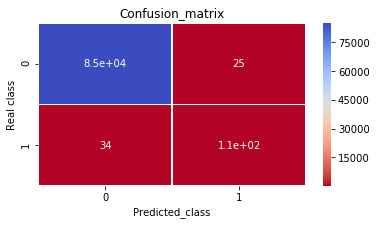


--------------------------------Precession and Recall---------------------------------
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     85302
      Fraud       0.81      0.76      0.78       141

avg / total       1.00      1.00      1.00     85443



In [30]:
# Initialize classifier
rf = RandomForestClassifier(class_weight = {0: 1, 1: 15})
rf_params = {'max_depth':[2, 5], 'n_estimators':[150, 180, 200]}
rf_gs = GridSearchCV(rf,rf_params,scoring='f1',cv=5)
rf_gs.fit(X_train,y_train)
print ("_________________________________Model Selection_____________________________________")
print ("Best estimator found by grid search:",rf_gs.best_estimator_)
print ("Best parameters found by grid search:",rf_gs.best_params_)
print ("Best accuracy score found by grid search:",rf_gs.best_score_)
print ()

# Predict new values using best model derived from cross validation and test performance on the test set
rf_pred = rf_gs.predict(X_test)
rf_prob = rf_gs.predict_proba(X_test)
rf_score = rf_gs.score(X_test, y_test)
print ("________________________________Model Prediction_____________________________________")
print ('F1-measure:', rf_score)
print ()
classifier_measures(y_test,rf_pred)

In [16]:
start = timeit.default_timer()
rf_gs.fit(X_train, y_train)
stop = timeit.default_timer()
print("Fitting Time: %s seconds" % (stop - start))

Fitting Time: 1607.4323735965809 seconds


### XGboost
To save time, I will only tune some parameters and it already got better results than other models. To improve the prediction performance, it's better to have more steps to tune the parameters. Details refer:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

_________________________________Model Selection_____________________________________
Best estimator found by grid search: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=180,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=15, seed=123,
       silent=True, subsample=1)
Best parameters found by grid search: {'max_depth': 5, 'n_estimators': 180}
Best accuracy score found by grid search: 0.871339282506

________________________________Model Prediction_____________________________________
F1-measure: 0.825278810409

-------------------------------------Accuracy-----------------------------------------
Accuracy: 0.999449925681
---------------------------------Confusion Matrix-------------------------------------
TP 111
TN 85285
FP 17
FN 30


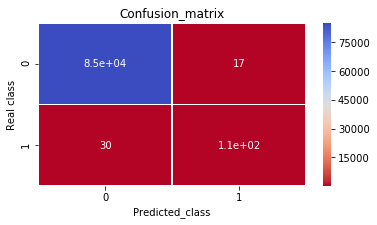


--------------------------------Precession and Recall---------------------------------
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     85302
      Fraud       0.87      0.79      0.83       141

avg / total       1.00      1.00      1.00     85443



In [12]:
# Initialize classifier
xgb = XGBClassifier( scale_pos_weight = 15,learning_rate =0.1,objective= 'binary:logistic',seed=123)
xgb_params = {'max_depth':[2, 5], 'n_estimators':[150, 180, 200]}
xgb_gs = GridSearchCV(xgb,xgb_params,scoring='f1',cv=5)
xgb_gs.fit(X_train,y_train)
print ("_________________________________Model Selection_____________________________________")
print ("Best estimator found by grid search:",xgb_gs.best_estimator_)
print ("Best parameters found by grid search:",xgb_gs.best_params_)
print ("Best accuracy score found by grid search:",xgb_gs.best_score_)
print ()

# Predict new values using best model derived from cross validation and test performance on the test set
xgb_pred = xgb_gs.predict(X_test)
xgb_prob = xgb_gs.predict_proba(X_test)
xgb_score = xgb_gs.score(X_test, y_test)
print ("________________________________Model Prediction_____________________________________")
print ('F1-measure:', xgb_score)
print ()
classifier_measures(y_test,xgb_pred)

#### Feature importance

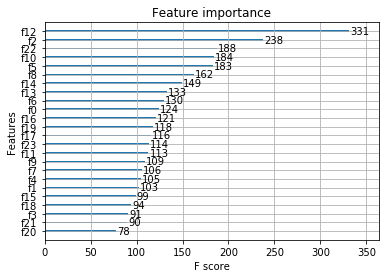

In [18]:
plot_importance(xgb_gs.best_estimator_)
plt.show()

## ROC and AUC

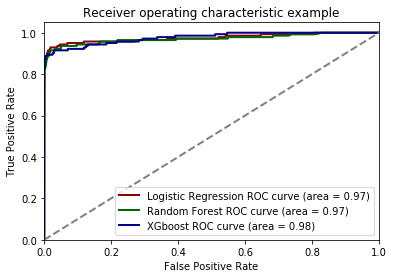

In [31]:
##roc curve
fpr = dict()
tpr = dict()
threholds = dict()
roc_auc = dict()
classlabel = 1

#Plot of a ROC curve for a specific class
plt.figure()
lw = 2

fpr, tpr, thresholds = roc_curve(y_test, lgr_prob[:, classlabel])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkred',
         lw=lw, label='Logistic Regression ROC curve (area = {:.2f})'.format(roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, rf_prob[:, classlabel])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkgreen',
         lw=lw, label='Random Forest ROC curve (area = {:.2f})'.format(roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, xgb_prob[:, classlabel])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkblue',
         lw=lw, label='XGboost ROC curve (area = {:.2f})'.format(roc_auc))


plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Model Selection

#### In this case, XGboost performance surpasses other models, I will choose XGboost

## Set Alert Threshold based on objectives
### 1. I would set the optimal threhold that could maxmize f measure while maitain both fraud recall and fraud precision above 80%.

In [19]:
## Combine probability with actual Class
prob = pd.Series(xgb_prob[:,1])
target = y_test.reset_index()['Class']
df_p = pd.DataFrame(dict(prob = prob, Class = target, Predict = ""))

In [20]:
## Sort by probability from high to low
df_sort = df_p.sort_values(by=['prob'],ascending=False)

In [27]:
f1_max = 0

for i in range(99,1,-1):
    cut_off = i/100
    df_sort['Predict'] = np.where(df_sort['prob']>cut_off,1,0)
    cmatrix = confusion_matrix(df_sort['Class'],df_sort['Predict'])
    fraud_precision = cmatrix[1,1]/(cmatrix[0,1]+cmatrix[1,1])
    fraud_recall = cmatrix[1,1]/(cmatrix[1,0]+cmatrix[1,1])
    fraud_f1 = 2*fraud_precision*fraud_recall/(fraud_precision+fraud_recall)
    accuracy = (cmatrix[0,0]+cmatrix[1,1])/(cmatrix[0,0]+cmatrix[1,1]+ cmatrix[0,1]+cmatrix[1,0])
    
    
    if fraud_recall > 0.8 and fraud_precision > 0.8 and fraud_f1> f1_max:
        f1_max = fraud_f1
        precision_opt = fraud_precision
        recall_opt = fraud_recall
        cut_off_opt = cut_off
        cmatrix_opt = cmatrix
        accuracy_opt = accuracy
        

print("Cut_off",cut_off_opt)
print("f1:",f1_max)
print("precision",precision_opt)
print("recall",recall_opt)
print("confusion matrix:", cmatrix_opt)
print("accuracy",accuracy_opt)

Cut_off 0.18
f1: 0.825622775801
precision 0.828571428571
recall 0.822695035461
confusion matrix: [[85278    24]
 [   25   116]]
accuracy 0.999426518264


### 2. I would set the optimal threhold that could maxmize f measure while maitain both fraud recall and fraud precision above 70%.

In [25]:
f1_max = 0

for i in range(99,1,-1):
    cut_off = i/100
    df_sort['Predict'] = np.where(df_sort['prob']>cut_off,1,0)
    cmatrix = confusion_matrix(df_sort['Class'],df_sort['Predict'])
    fraud_precision = cmatrix[1,1]/(cmatrix[0,1]+cmatrix[1,1])
    fraud_recall = cmatrix[1,1]/(cmatrix[1,0]+cmatrix[1,1])
    fraud_f1 = 2*fraud_precision*fraud_recall/(fraud_precision+fraud_recall)
    accuracy = (cmatrix[0,0]+cmatrix[1,1])/(cmatrix[0,0]+cmatrix[1,1]+ cmatrix[0,1]+cmatrix[1,0])
    
    
    if fraud_recall > 0.7 and fraud_precision > 0.7 and fraud_f1> f1_max:
        f1_max = fraud_f1
        precision_opt = fraud_precision
        recall_opt = fraud_recall
        cut_off_opt = cut_off
        cmatrix_opt = cmatrix
        accuracy_opt = accuracy
        

print("Cut_off",cut_off_opt)
print("f1:",f1_max)
print("precision",precision_opt)
print("recall",recall_opt)
print("confusion matrix:", cmatrix_opt)
print("accuracy",accuracy_opt)

Cut_off 0.95
f1: 0.83137254902
precision 0.929824561404
recall 0.751773049645
confusion matrix: [[85294     8]
 [   35   106]]
accuracy 0.999496740517


###  To achieve different objectives, we could set different alert threshold. If we want to get high fraud recall rate, the cut_off value would be small such as 0.18, therefore we could reduce fraud by 83%. If we want to maintain the recall and precision both above 70%, we should set cut_off as 0.95, which could reduce almost 75% of the fraud while the precision would also be greater than 93%.